# Smart Meters in London: Data Analysis and ML model (Part 3/3)

This jupyter notebook wants to analyse the data coming from the energy consumption of different users, to see how a forecast algorithm can be developed, or clustering models can be done. 

The structure of this notebook is as follows: 

Analysis of different household, according to different types of tariffs, to see whether there are different patterns. 


## 1. Preprocessing: Libraries and files reading

In [16]:
# Importing libraries required for the analysis 
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns 
import datetime as dt
from sqlalchemy import create_engine 
import os
import sklearn 

# Importing libraries required for T-S analysis
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.ar_model import AR
from statsmodels.tsa.arima_model import ARMA
from pandas.plotting import lag_plot
import itertools

# Seting style for matplotlib
plt.style.use('ggplot')

In [17]:
# Reading the current working directoy to see where are we writing the code. 
os.getcwd()

'/home/ingrid/Documents/DA_Ironhack/Week8/Final_Project/2.JupyterNotebooks'

In [18]:
# Seeing all the files we have in clean_data folder 
os.listdir('../0.Data/clean_data')

['halfhourly_block12_cleaned.csv',
 'MAC000291_cleaned_consumption.csv',
 'info_househoulds_cleaned.csv',
 'weather_hourly_cleaned.csv',
 'info_households_cleaned.csv']

In [19]:
# Reading the csv file
users_info = pd.read_csv('../0.Data/clean_data/info_househoulds_cleaned.csv', index_col=0)

In [20]:
users_info.head()

,LCLid,stdorToU,Acorn,Acorn_grouped,file
0,MAC005492,ToU,ACORN-,ACORN-,block_0
1,MAC001074,ToU,ACORN-,ACORN-,block_0
2,MAC000002,Std,ACORN-A,Affluent,block_0
3,MAC003613,Std,ACORN-A,Affluent,block_0
4,MAC003597,Std,ACORN-A,Affluent,block_0


In [21]:
# Changing the name of the columns to a better one. 
users_info.columns = ['LCLid', 'tariff', 'acorn_class', 'acorn_group', 'file']

In [22]:
# Counting how many clients we have under each type of tariff.
users_info['tariff'].value_counts()

Std    4443
ToU    1123
Name: tariff, dtype: int64

## Types of tariff and clients associated to each

Text(0.5, 0, 'Type of tariff')

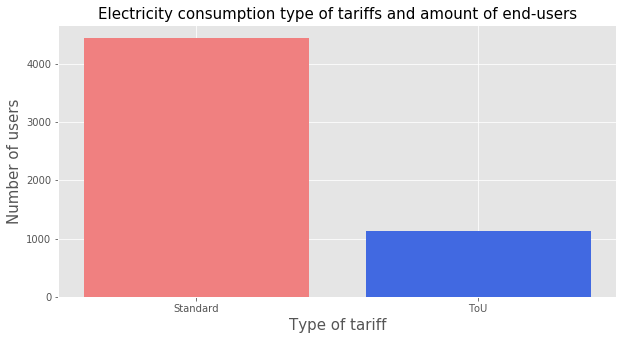

In [23]:
# Plotting how many clients we have under each tariff 
plt.figure(figsize=(10,5))
plt.bar(x=['Standard','ToU'], height=users_info['tariff'].value_counts(), color=['lightcoral', 'royalblue'])

# Setting aesthetics on the plot 
plt.title("Electricity consumption type of tariffs and amount of end-users", fontsize=15)
plt.ylabel("Number of users", fontsize=15)
plt.xlabel('Type of tariff', fontsize=15)

As we can see from the graph above, there are two different types of tariff that the user can contract: **Standard** and **ToU**. Also we can see that there is a huge tendency on the amount of users to have a Standard contract instead of a ToU contract. 


We will choose two end-users with a Standard Tariff contracted and later on we will choose two end-users with a ToU tariff, to see whether there are significant differences in the model. 

Since we have cleaned the data belonging to block_12, we will first analyse those end users that belong to each type of tariff and also belong to block_12.

In [24]:
# Filtering our dataframe to those that have a ToU tariff and belong to block_12
users_info[(users_info['tariff']=='ToU') & (users_info['file']=='block_12')].head()

,LCLid,tariff,acorn_class,acorn_group,file
600,MAC005106,ToU,ACORN-D,Affluent,block_12
604,MAC005179,ToU,ACORN-D,Affluent,block_12
610,MAC001495,ToU,ACORN-D,Affluent,block_12
611,MAC002622,ToU,ACORN-D,Affluent,block_12
613,MAC002645,ToU,ACORN-D,Affluent,block_12


In [25]:
# Filtering our dataframe to those that have a Std tariff and belong to block_12
users_info[(users_info['tariff']=='Std') & (users_info['file']=='block_12')].head()

,LCLid,tariff,acorn_class,acorn_group,file
601,MAC004340,Std,ACORN-D,Affluent,block_12
602,MAC002137,Std,ACORN-D,Affluent,block_12
603,MAC001800,Std,ACORN-D,Affluent,block_12
605,MAC005182,Std,ACORN-D,Affluent,block_12
606,MAC004280,Std,ACORN-D,Affluent,block_12


We will use the data coming from two users with ToU Tariff and two with Std Tariff that they are also in block_12 since it is the block that we have cleaned before. We will import block_12 to analyse these data. 

`ToU users`: MAC001495 and MAC002645

`Standard users`: MAC001800 and MAC004280 and MAC000291

In [26]:
# Importing block_12 file 
half_hourly_df = pd.read_csv('../0.Data/clean_data/halfhourly_block12_cleaned.csv', index_col=0)

/home/linuxbrew/.linuxbrew/opt/python/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


## Standard Users. MAC000291

In [28]:
MAC000291_df = half_hourly_df[half_hourly_df['LCLid']=='MAC000291']

In [29]:
MAC000291_df.head()

,LCLid,DateTime,kWh/hh
0,MAC000291,2012-03-02 09:30:00,1.158
1,MAC000291,2012-03-02 10:00:00,1.499
2,MAC000291,2012-03-02 10:30:00,1.433
3,MAC000291,2012-03-02 11:00:00,0.510
4,MAC000291,2012-03-02 11:30:00,0.455


In [30]:
MAC000291_df.dtypes

LCLid        object
DateTime     object
kWh/hh      float64
dtype: object

In [31]:
def df_arrange(df, id_column, dt_column):
    # Changing the type of DateTime column into DateTime 
    
    df[dt_column] = pd.to_datetime(df[dt_column])

    # Setting DateTime as index of the dataframe 
    df.index = df[dt_column].sort_index()

    # Droping DateTime and LCLid columns 
    df.drop([id_column, dt_column], axis = 1, inplace = True )
    
    # Changing names of the columns
    df.columns= ['kWh']
    
    # Resample df into hourly data 
    return df.resample('H').sum()

In [32]:
MAC000291_df_h = df_arrange(MAC000291_df, 'LCLid', 'DateTime' )

/home/linuxbrew/.linuxbrew/opt/python/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.
/home/linuxbrew/.linuxbrew/opt/python/lib/python3.7/site-packages/pandas/core/frame.py:3940: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


In [33]:
MAC000291_df_h.head()

,kWh
DateTime,
2012-03-02 09:00:00,1.158
2012-03-02 10:00:00,2.932
2012-03-02 11:00:00,0.965
2012-03-02 12:00:00,0.734
2012-03-02 13:00:00,0.694


/home/linuxbrew/.linuxbrew/opt/python/lib/python3.7/site-packages/pandas/plotting/_converter.py:129: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


NameError: name 'moving_avg_24h' is not defined

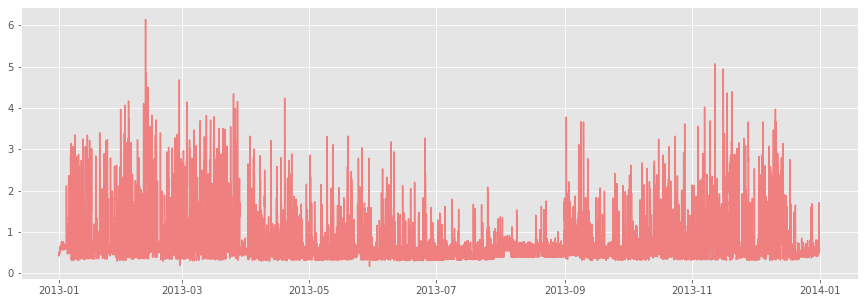

In [34]:
plt.figure(figsize=(15,5))
plt.plot(MAC000291_df_h['2013'], color='lightcoral')
plt.plot(moving_avg_24h, color='royalblue' )
plt.title('User MAC000291 Electricity Consumption in 2013')
plt.xlabel('time unit [h]', fontsize=12)
plt.ylabel('Electricity Consumption [kWh]', fontsize=12)

plt.xlim('2013-01-01 00:00:00', '2014-01-01 00:00:00')
plt.show()

In [ ]:
plt.figure(figsize=(15,5))
plt.plot(MAC000291_df_h['2013-02'], color='lightcoral')
plt.plot(moving_avg_24h, color='royalblue', linestyle=':' )
plt.title('User MAC000291 Electricity Consumption in February 2013. Time resolution comparison')
plt.xlabel('time unit [h]', fontsize=12)
plt.ylabel('Electricity Consumption [kWh]', fontsize=12)

plt.xlim('2013-02-01 00:00:00', '2013-03-01 00:00:00')
plt.show()

In [35]:
moving_avg_1h = MAC000291_df_h.rolling(window=1).mean()
moving_avg_2h = MAC000291_df_h.rolling(window=2).mean()
moving_avg_12h = MAC000291_df_h.rolling(window=12).mean()
moving_avg_24h = MAC000291_df_h.rolling(window=24).mean()

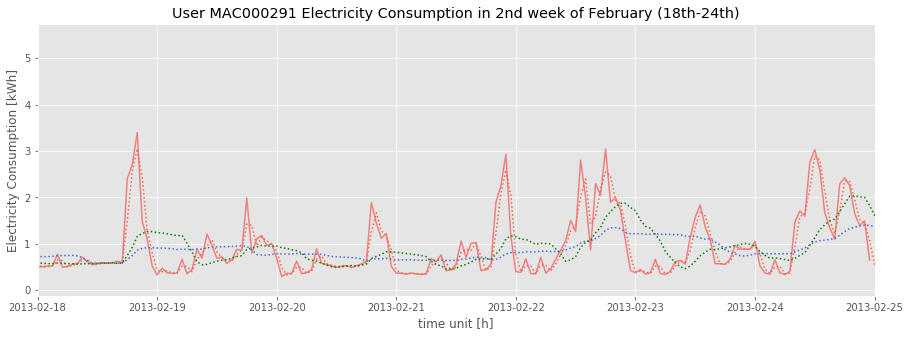

In [36]:
plt.figure(figsize=(15,5))
plt.plot(MAC000291_df_h['2013-02-18':'2013-02-24'], color='lightcoral')
#plt.plot(moving_avg_1h, color='black', linestyle=':' )
plt.plot(moving_avg_24h, color='royalblue', linestyle=':' )
plt.plot(moving_avg_2h, color='tomato', linestyle=':' )
plt.plot(moving_avg_12h, color='green', linestyle=':' )
plt.title('User MAC000291 Electricity Consumption in 2nd week of February (18th-24th)')
plt.xlabel('time unit [h]', fontsize=12)
plt.ylabel('Electricity Consumption [kWh]', fontsize=12)

plt.xlim('2013-02-18 00:00:00', '2013-02-25 00:00:00')
plt.show()

## Standard User. MAC004280
 

In [37]:
MAC004280_df = half_hourly_df[half_hourly_df['LCLid']=='MAC004280']
MAC004280_df_h = df_arrange(MAC004280_df , 'LCLid', 'DateTime' )

/home/linuxbrew/.linuxbrew/opt/python/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


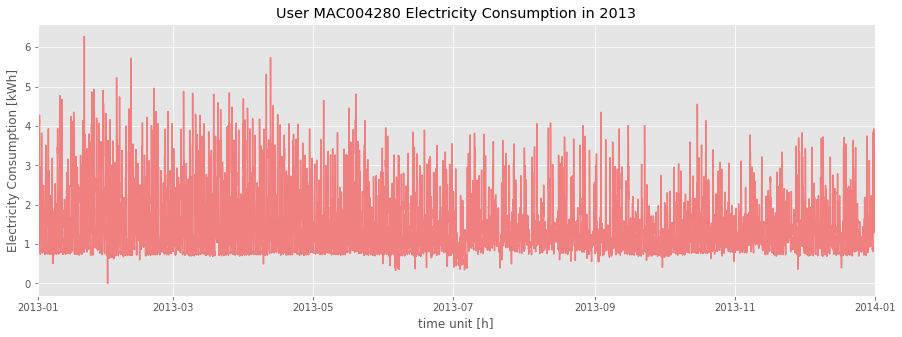

In [38]:
plt.figure(figsize=(15,5))
plt.plot(MAC004280_df_h['2013'], color='lightcoral')
#plt.plot(moving_avg_24h, color='royalblue' )
plt.title('User MAC004280 Electricity Consumption in 2013')
plt.xlabel('time unit [h]', fontsize=12)
plt.ylabel('Electricity Consumption [kWh]', fontsize=12)

plt.xlim('2013-01-01 00:00:00', '2014-01-01 00:00:00')
plt.show()

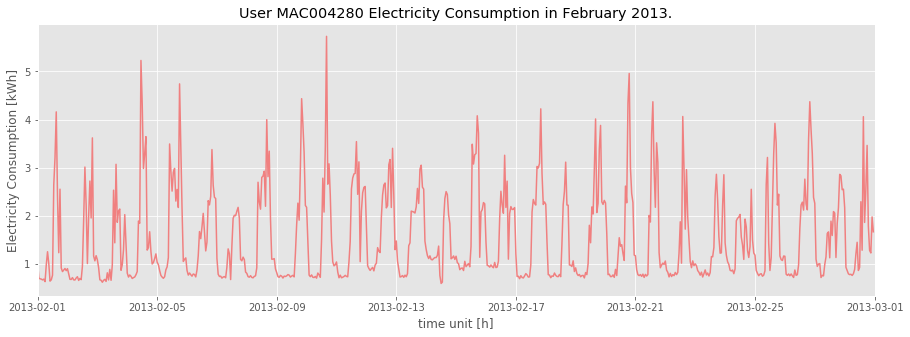

In [39]:
plt.figure(figsize=(15,5))
plt.plot(MAC004280_df_h['2013-02'], color='lightcoral')
#plt.plot(moving_avg_24h, color='royalblue', linestyle=':' )
plt.title('User MAC004280 Electricity Consumption in February 2013.')
plt.xlabel('time unit [h]', fontsize=12)
plt.ylabel('Electricity Consumption [kWh]', fontsize=12)

plt.xlim('2013-02-01 00:00:00', '2013-03-01 00:00:00')
plt.show()

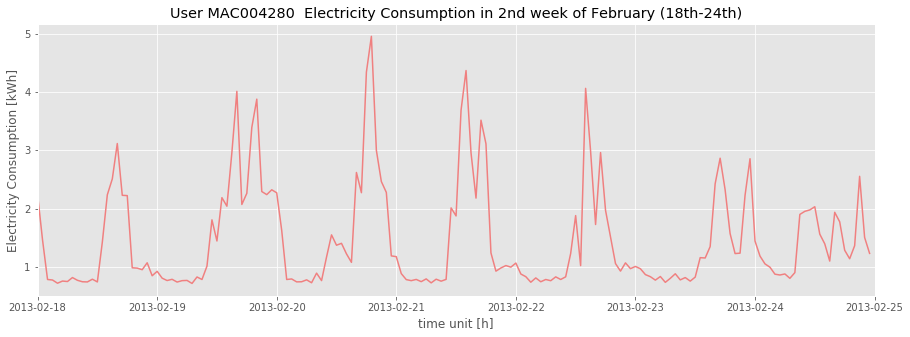

In [40]:
plt.figure(figsize=(15,5))
plt.plot(MAC004280_df_h['2013-02-18':'2013-02-24'], color='lightcoral')
#plt.plot(moving_avg_1h, color='black', linestyle=':' )
# plt.plot(moving_avg_24h, color='royalblue', linestyle=':' )
# plt.plot(moving_avg_2h, color='tomato', linestyle=':' )
# plt.plot(moving_avg_12h, color='green', linestyle=':' )
plt.title('User MAC004280  Electricity Consumption in 2nd week of February (18th-24th)')
plt.xlabel('time unit [h]', fontsize=12)
plt.ylabel('Electricity Consumption [kWh]', fontsize=12)

plt.xlim('2013-02-18 00:00:00', '2013-02-25 00:00:00')
plt.show()

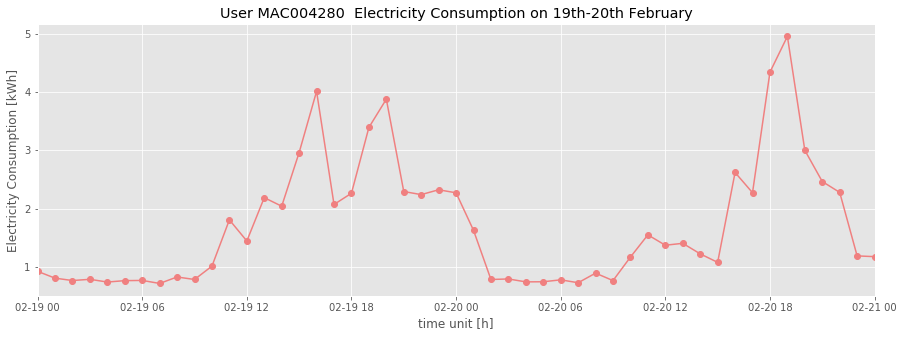

In [41]:
plt.figure(figsize=(15,5))
plt.plot(MAC004280_df_h['2013-02-19':'2013-02-21'], color='lightcoral', marker='o')
#plt.plot(moving_avg_1h, color='black', linestyle=':' )
# plt.plot(moving_avg_24h, color='royalblue', linestyle=':' )
#plt.plot(moving_avg_2h, color='tomato', linestyle=':' )
# plt.plot(moving_avg_12h, color='green', linestyle=':' )
plt.title('User MAC004280  Electricity Consumption on 19th-20th February')
plt.xlabel('time unit [h]', fontsize=12)
plt.ylabel('Electricity Consumption [kWh]', fontsize=12)

plt.xlim('2013-02-19 00:00:00', '2013-02-21 00:00:00')
plt.show()

## ToU Tariff. MAC001495

In [42]:
MAC001495_df = half_hourly_df[half_hourly_df['LCLid']=='MAC001495']
MAC001495_df_h = df_arrange(MAC001495_df , 'LCLid', 'DateTime' )

/home/linuxbrew/.linuxbrew/opt/python/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


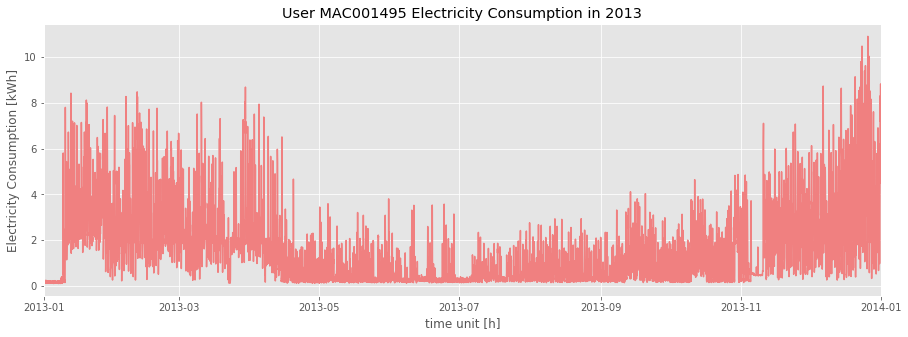

In [43]:
plt.figure(figsize=(15,5))
plt.plot(MAC001495_df_h['2013'], color='lightcoral')
#plt.plot(moving_avg_24h, color='royalblue' )
plt.title('User MAC001495 Electricity Consumption in 2013')
plt.xlabel('time unit [h]', fontsize=12)
plt.ylabel('Electricity Consumption [kWh]', fontsize=12)

plt.xlim('2013-01-01 00:00:00', '2014-01-01 00:00:00')
plt.show()

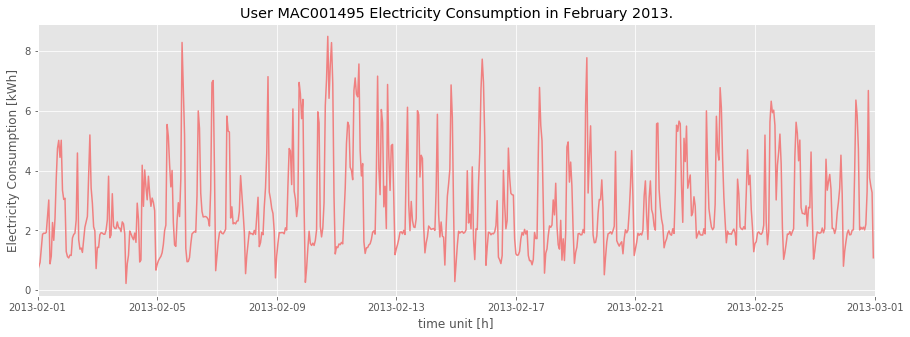

In [44]:
plt.figure(figsize=(15,5))
plt.plot(MAC001495_df_h['2013-02'], color='lightcoral')
#plt.plot(moving_avg_24h, color='royalblue', linestyle=':' )
plt.title('User MAC001495 Electricity Consumption in February 2013.')
plt.xlabel('time unit [h]', fontsize=12)
plt.ylabel('Electricity Consumption [kWh]', fontsize=12)

plt.xlim('2013-02-01 00:00:00', '2013-03-01 00:00:00')
plt.show()

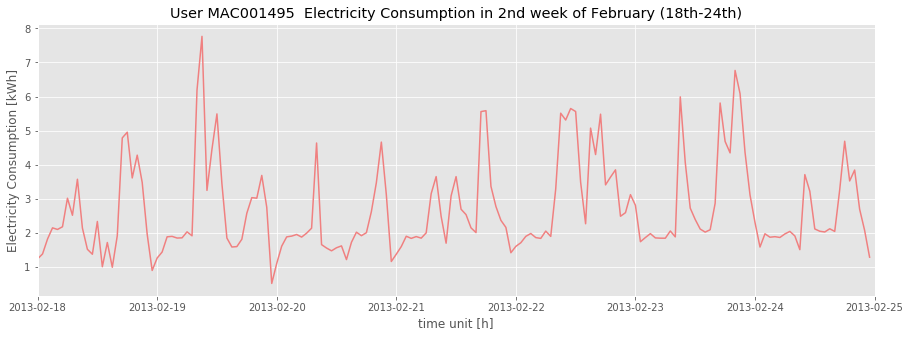

In [45]:
plt.figure(figsize=(15,5))
plt.plot(MAC001495_df_h['2013-02-18':'2013-02-24'], color='lightcoral')
#plt.plot(moving_avg_1h, color='black', linestyle=':' )
# plt.plot(moving_avg_24h, color='royalblue', linestyle=':' )
# plt.plot(moving_avg_2h, color='tomato', linestyle=':' )
# plt.plot(moving_avg_12h, color='green', linestyle=':' )
plt.title('User MAC001495  Electricity Consumption in 2nd week of February (18th-24th)')
plt.xlabel('time unit [h]', fontsize=12)
plt.ylabel('Electricity Consumption [kWh]', fontsize=12)

plt.xlim('2013-02-18 00:00:00', '2013-02-25 00:00:00')
plt.show()

## ToU Tariff. MAC002645

In [46]:
MAC002645_df = half_hourly_df[half_hourly_df['LCLid']=='MAC002645']
MAC002645_df_h = df_arrange(MAC002645_df , 'LCLid', 'DateTime' )

/home/linuxbrew/.linuxbrew/opt/python/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


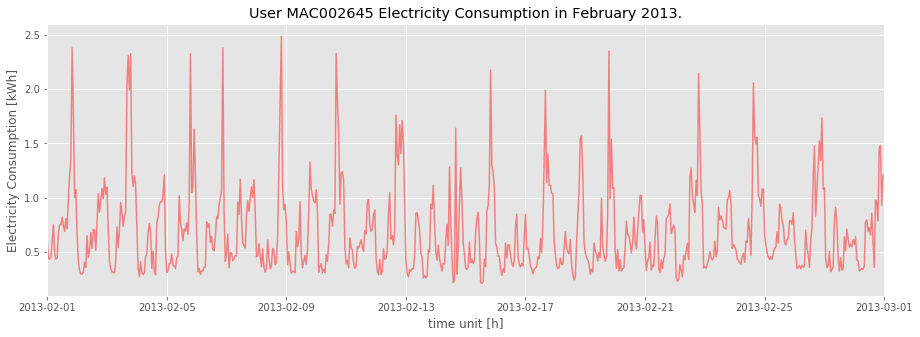

In [47]:
plt.figure(figsize=(15,5))
plt.plot(MAC002645_df_h['2013-02'], color='lightcoral')
#plt.plot(moving_avg_24h, color='royalblue', linestyle=':' )
plt.title('User MAC002645 Electricity Consumption in February 2013.')
plt.xlabel('time unit [h]', fontsize=12)
plt.ylabel('Electricity Consumption [kWh]', fontsize=12)

plt.xlim('2013-02-01 00:00:00', '2013-03-01 00:00:00')
plt.show()

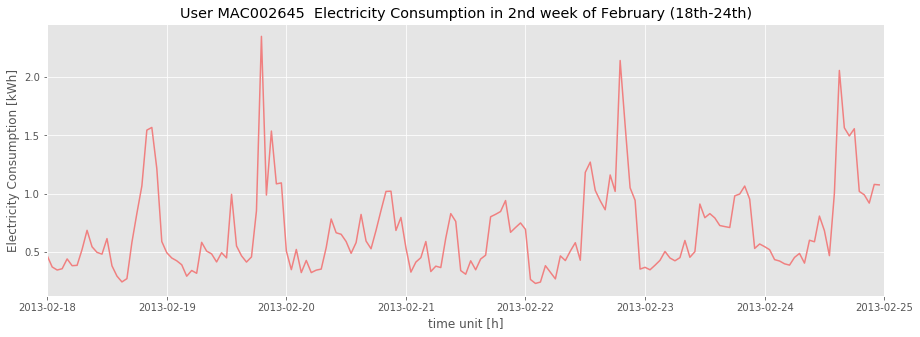

In [51]:
plt.figure(figsize=(15,5))
plt.plot(MAC002645_df_h['2013-02-18':'2013-02-24'], color='lightcoral')
#plt.plot(MAC004280_df_h['2013-02-18':'2013-02-24'], color='royalblue')
#plt.plot(MAC000291_df_h['2013-02-18':'2013-02-24'], color='green')
#plt.plot(moving_avg_1h, color='black', linestyle=':' )
# plt.plot(moving_avg_24h, color='royalblue', linestyle=':' )
# plt.plot(moving_avg_2h, color='tomato', linestyle=':' )
# plt.plot(moving_avg_12h, color='green', linestyle=':' )
plt.title('User MAC002645  Electricity Consumption in 2nd week of February (18th-24th)')
plt.xlabel('time unit [h]', fontsize=12)
plt.ylabel('Electricity Consumption [kWh]', fontsize=12)

plt.xlim('2013-02-18 00:00:00', '2013-02-25 00:00:00')
plt.show()

## 2. Clustering clients 

Our second objective of the project is to be able to perform a market segmentation of our clients based on their electricity consumption. For this reason, we would like to perform a clustering of our clients to know if we could create new tariffs for them. In this case, we are using the dataset that contains all the information regarding their daily consumption.

Our first question here is: 

**Can we classify our clients only considering their daily consumption?** 

or, otherwise, 

**We need more granularity and we should analyze their daily consumption in an hourly timescale?**

In this first chapter we want to analyze if we can classify our clients just considering their daily consumption.

### 2.1. Data preprocessing

In [10]:
# Reading the csv file 
clients_cons = pd.read_csv('../0.Data/raw_data/daily_dataset.csv')

In [11]:
# Taking a look on the df 
clients_cons.head()

,LCLid,day,energy_median,energy_mean,energy_max,energy_count,energy_std,energy_sum,energy_min
0,MAC000131,2011-12-15,0.4850,0.432045,0.868,22,0.239146,9.505,0.072
1,MAC000131,2011-12-16,0.1415,0.296167,1.116,48,0.281471,14.216,0.031
2,MAC000131,2011-12-17,0.1015,0.189812,0.685,48,0.188405,9.111,0.064
3,MAC000131,2011-12-18,0.1140,0.218979,0.676,48,0.202919,10.511,0.065
4,MAC000131,2011-12-19,0.1910,0.325979,0.788,48,0.259205,15.647,0.066


In [52]:
# Checking the types in our df. 
clients_cons.dtypes

LCLid             object
day               object
energy_median    float64
energy_mean      float64
energy_max       float64
energy_count       int64
energy_std       float64
energy_sum       float64
energy_min       float64
dtype: object

In [54]:
# Changing the type of the day column into datetime for a better analysis. 
clients_cons['day'] = pd.to_datetime(clients_cons['day'])

In [55]:
# Checking the types in our df. 
clients_cons.dtypes

LCLid                    object
day              datetime64[ns]
energy_median           float64
energy_mean             float64
energy_max              float64
energy_count              int64
energy_std              float64
energy_sum              float64
energy_min              float64
dtype: object

In [13]:
# Checking how many observations the df has. 
clients_cons.shape

(3510433, 9)

We want to analyse whether we have the same amount of measurements for each end-user. We know that each measure coming from the smart meter is taken in a half-hour basis. That means that we should have 48 measurements per day. 

For this reason, if we only have one measure, it would be better to drop this measure out of the model. Also, because if we only have one measure in our model, it is not possible to calculate the standard deviation on that day. 

In [61]:
# Checking how many measurements we have in total in our dataframe. 
clients_cons['energy_count'].value_counts().sort_index(ascending=False)

48    3469352
47      21209
46       1005
45        426
44        290
43        252
42        204
41        164
40        233
39        112
38         92
37         69
36         56
35         39
34         43
33         39
32        274
31        399
30        529
29        544
28        543
27        501
26        510
25        421
24        423
23        369
22        318
21        250
20        168
19        132
18         65
17         29
16         15
15         12
14          2
13          2
12          2
11          1
10          2
9           2
8           2
4           2
1       11301
0          30
Name: energy_count, dtype: int64

In [14]:
# Checking how many measurements we have for each user. 
clients_cons['LCLid'].value_counts()

MAC000145    829
MAC000147    829
MAC000155    829
MAC000157    829
MAC000148    829
MAC000152    829
MAC000149    829
MAC000153    829
MAC000150    829
MAC000151    829
MAC000156    829
MAC000168    828
MAC000165    828
MAC000162    828
MAC000167    828
MAC000158    828
MAC000159    828
MAC000166    828
MAC000169    828
MAC000160    828
MAC000163    828
MAC000170    827
MAC000171    827
MAC000173    827
MAC000174    827
MAC000176    827
MAC000175    827
MAC000179    826
MAC000180    826
MAC000185    826
            ... 
MAC003770    189
MAC004612    184
MAC002014    180
MAC002155    177
MAC003197    165
MAC003592    164
MAC005510    162
MAC003481    162
MAC003347    162
MAC003207    158
MAC003202    157
MAC004679    142
MAC003572    134
MAC001477    129
MAC003935    124
MAC003559    123
MAC003554    109
MAC003353    107
MAC001653    101
MAC003346     88
MAC001957     17
MAC002110     12
MAC001278     12
MAC001300     10
MAC005565      3
MAC005556      1
MAC001150      1
MAC005559     

We can also calculate how many missing values we have in our database. With this is mind, we can calculate the amount of data we would loose if we decide to drop them out of the model.

In [60]:
clients_cons.isna().sum()

LCLid                0
day                  0
energy_median       30
energy_mean         30
energy_max          30
energy_count         0
energy_std       11331
energy_sum          30
energy_min          30
dtype: int64

In the case of the standard deviation, if we drop the rows with missing values, we would loose approximately a 3% of data. Also, in this case, we cannot calculate the standard deviation and include it here. For this reason, we decide to drop them out of the model. 

In [63]:
clients_cons.dropna(inplace= True)

In [65]:
clients_cons.shape

(3499102, 9)

Considering the previous number of rows and the number of rows after droping them out of the model, we can see that we have removed 11331 rows from our model, and that all the missing values were gathered around the same rows. 

In [67]:
# Checking that we no longer have missing values
clients_cons.isna().sum()

LCLid            0
day              0
energy_median    0
energy_mean      0
energy_max       0
energy_count     0
energy_std       0
energy_sum       0
energy_min       0
dtype: int64

After removing all the NaN values, we have to consider if we want in our model some daily information from our user that does not contain the 48 measures a smart meter should do daily. If we calculate the percentage of users on which we have 48 measurements per day, we see that we have:

In [70]:
(clients_cons[clients_cons['energy_count']==48].shape[0]/clients_cons.shape[0])*100

99.14978185831679

In [71]:
clients_cons[clients_cons['energy_count']==48].shape[0]

3469352

More than 99% of data. For this reason, we will remove all the measurements on which we don't have 48 measurements for each day. 

In [73]:
clients_daily_cons = clients_cons[clients_cons['energy_count']==48]

In [74]:
clients_daily_cons.shape

(3469352, 9)

In [75]:
# Checking how many measurements we have in total in our dataframe. 
clients_daily_cons['energy_count'].value_counts().sort_index(ascending=False)

48    3469352
Name: energy_count, dtype: int64

## 2.2. ML Model: Clustering

In our case, we have only two labels for our users, according to the type of tariff that we have. Furthermore, we would like to increment the number of tariff our model has. For this reason, we would go for an Unsupervised Algorithm for Clustering. Under this approach, we would try to work with two different algorithms: 

- K-Means
- DBscan